## Checking Assumptions for Linear Regression
If one of the assumptions of normality or equal variance is violated, we cannot perform any of our linear regression techniques for our data analysis. The next steps would be to re-evaluate the dataset and examine any missed outliers skewing our data excessively and/or any data transformations. 

In [1]:
# importing appropriate packages
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import plotly.express as px
import re
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from statsmodels.formula.api import ols
from statsmodels.graphics.factorplots import interaction_plot
from scipy.stats import boxcox, levene, norm, mode
from sklearn.preprocessing import PowerTransformer
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")

In [2]:
# reading in the dataset
df = pd.read_csv("https://raw.githubusercontent.com/gspiga/STA160/main/Final%20Project/Data/data.csv", index_col=[0])
df.head()

,state,county,area_sqmi,epl_pov,epl_unemp,epl_pci,epl_nohsdp,spl_theme1,rpl_theme1,epl_age65,...,f_minrty,f_limeng,f_theme3,f_munit,f_mobile,f_crowd,f_noveh,f_groupq,f_theme4,f_total
0,ALABAMA,Autauga,594.443459,0.5401,0.2745,0.2860,0.4397,1.5403,0.3631,0.1850,...,0,0,0,0,0,0,0,0,0,0
1,ALABAMA,Baldwin,1589.793007,0.2239,0.3121,0.2057,0.3209,1.0626,0.2232,0.6428,...,0,0,0,1,0,0,0,0,1,1
2,ALABAMA,Barbour,885.001636,0.9631,0.9217,0.9481,0.9701,3.8030,0.9780,0.4893,...,0,0,0,0,1,0,0,1,2,8
3,ALABAMA,Bibb,622.461089,0.4430,0.7895,0.8987,0.7351,2.8663,0.7694,0.3200,...,0,0,0,0,1,0,0,1,2,2
4,ALABAMA,Blount,644.830460,0.4723,0.2611,0.7561,0.8405,2.3300,0.6143,0.4715,...,0,0,0,0,0,0,0,0,0,0


### Normality Assumption
To visualize our data's compliance to the normality assumption, we will evaluate a normal probability plot with studentized residuals.

In [3]:
# creating dummy variables for flags (binary data)
df_OLS = pd.get_dummies(df,
    columns=[
        "f_pov",
        "f_unemp",
        "f_pci",
        "f_nohsdp",
        "f_age65",
        "f_age17",
        "f_disabl",
        "f_sngpnt",
        "f_minrty",
        "f_limeng",
        "f_munit",
        "f_mobile",
        "f_crowd",
        "f_noveh",
        "f_groupq"
    ],
)

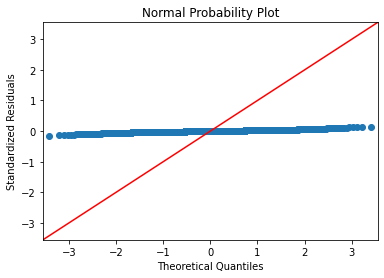

In [4]:
# building the model
model = ols("rpl_themes ~  area_sqmi + epl_pov + epl_unemp + epl_pci + epl_nohsdp + rpl_theme1 + epl_age65 + epl_age17 + epl_disabl + epl_sngpnt + rpl_theme2 + epl_minrty + epl_limeng + rpl_theme3+ epl_munit + epl_mobile + epl_crowd + epl_noveh + epl_groupq+ rpl_theme4 + f_theme1 + f_theme2 + f_theme3 + f_theme4 + f_total + f_pov_0 + f_pov_1 + f_unemp_0 + f_unemp_1 + f_pci_0 + f_pci_1+ f_nohsdp_0 + f_nohsdp_1 + f_age65_0 + f_age65_1 + f_age17_0 + f_age17_1 + f_disabl_0 + f_disabl_1 + f_sngpnt_0 + f_sngpnt_1 + f_minrty_0 + f_minrty_1 + f_limeng_0+ f_limeng_1 + f_munit_0 + f_munit_1 + f_mobile_0 + f_mobile_1 + f_crowd_0 + f_crowd_1 + f_noveh_0 + f_noveh_1 + f_groupq_0+ f_groupq_1 + spl_theme1 + spl_theme2 + spl_theme3 + spl_theme4 + spl_themes", data=df_OLS).fit()

# creating the normal probability plot
sm.qqplot(model.resid, line="45")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Standardized Residuals")
plt.title("Normal Probability Plot")
plt.show()

The points don't follow the line at all, with large quantiles (positive and negative) indicating heavy tails in the data's distribution. The data violates the normality assumption.

#### Box Cox Transformation

We will try performing a BoxCox transformation of the non-normal dependent variable (`rpl_themes`) in an effort to improve the data's compliance to the normality assumption.

In [5]:
# reference: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html
pt = PowerTransformer(method="yeo-johnson")
rpl_themes_df = pd.DataFrame(df_OLS["rpl_themes"])
pt.fit(rpl_themes_df)
print(pt.lambdas_)  # optimal lambda value

[0.74884275]


The above output is the optimal lambda value for the Box Cox transformation of our data. We will use it to transform the `rpl_themes` column and update our model.

In [6]:
# transform the rpl_themes column
transformed_data = pt.transform(rpl_themes_df)
df_OLS.insert(0, "rpl_themes_transformed", transformed_data)  # new column of transformed rpl_themes

Now that we have transformed the data again, let us recheck the assumptions.

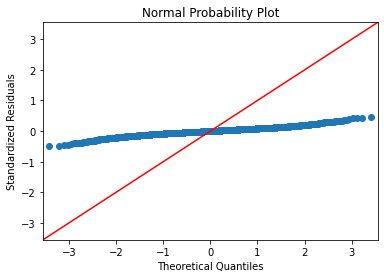

In [7]:
# building the model with the transformed data
model2 = ols("rpl_themes_transformed ~ area_sqmi + epl_pov + epl_unemp + epl_pci + epl_nohsdp + rpl_theme1 + epl_age65 + epl_age17 + epl_disabl + epl_sngpnt + rpl_theme2 + epl_minrty + epl_limeng + rpl_theme3+ epl_munit + epl_mobile + epl_crowd + epl_noveh + epl_groupq + rpl_theme4 + f_theme1 + f_theme2 + f_theme3 + f_theme4 + f_total + f_pov_0 + f_pov_1 + f_unemp_0 + f_unemp_1 + f_pci_0 + f_pci_1+ f_nohsdp_0 + f_nohsdp_1 + f_age65_0 + f_age65_1 + f_age17_0 + f_age17_1 + f_disabl_0 + f_disabl_1 + f_sngpnt_0 + f_sngpnt_1 + f_minrty_0 + f_minrty_1 + f_limeng_0+ f_limeng_1 + f_munit_0 + f_munit_1 + f_mobile_0 + f_mobile_1 + f_crowd_0 + f_crowd_1 + f_noveh_0 + f_noveh_1 + f_groupq_0+ f_groupq_1 + spl_theme1 + spl_theme2 + spl_theme3 + spl_theme4 + spl_themes", data=df_OLS).fit()

# creating the normal probability plot
sm.qqplot(model2.resid, line="45")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Standardized Residuals")
plt.title("Normal Probability Plot")
plt.show()

Even after the Boxcox transformation, the points don't follow the line at all, with large quantiles (positive and negative) indicating heavy tails in the data's distribution. The data still violates the normality assumption.

#### Shapiro-Wilk's Test
Since the residuals still show heavy tails, we will also perform a Shapiro-Wilk's test to quantify the ability to accept/reject the normality assumption.

In [8]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html
w, pvalue = stats.shapiro(model2.resid)
print(w, pvalue)

0.9763079881668091 1.8535733423523486e-22


Since the p-value of 1.8535733423523486e-22 is less than $\alpha$ = 0.05, we reject the null hypothesis. There is statistically significant evidence to suggest that the normality assumption does not hold.

#### Kolmogorov Smirnoff Test
We will also perform a Kolmogorov Smirnoff test to quantify the ability to accept/reject the normality assumption.

In [9]:
# reference: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kstest.html
stats.kstest(model2.resid, "norm")

KstestResult(statistic=0.40090695326002834, pvalue=0.0)

Since the p-value of 0.0 is less than $\alpha$ = 0.05, we reject the null hypothesis. There is statistically significant evidence to suggest that the normality assumption does not hold.

While the results from both of these findings contradict our residuals plot, we will use a histogram to visualize that the residuals are approximately normally distributed.

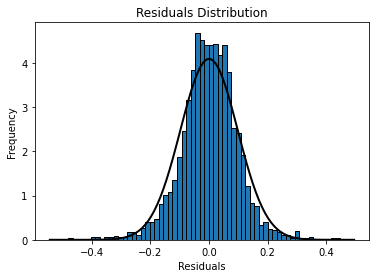

In [10]:
# plot the residuals as a histogram
plt.hist(model2.resid, bins="auto", density=True, histtype="bar", ec="k")
mu, std = norm.fit(model2.resid)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, "k", linewidth=2)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Residuals Distribution")
plt.show()

### Homoscedasticity Assumption

To visualize our data's compliance to the homoscedasticity assumption, we will evaluate the residuals vs. fitted plot, as well as the Scale-Location plot. This plot displays the model's fitted values vs. square root of the standardized residuals.

Text(0, 0.5, 'Residuals')

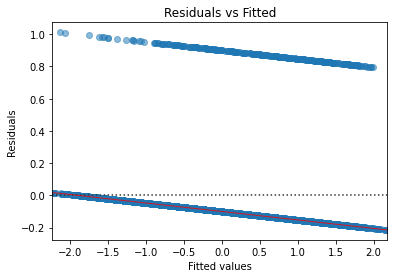

In [11]:
# Reference: https://robert-alvarez.github.io/2018-06-04-diagnostic_plots/

# fitted values
model_fitted_y = model2.fittedvalues
# residuals
model_residuals = model2.resid
# normalized residuals
model_norm_residuals = model2.get_influence().resid_studentized_internal
# absolute squared normalized residuals
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
# absolute residuals
model_abs_resid = np.abs(model_residuals)
# leverage, from statsmodels internals
model_leverage = model2.get_influence().hat_matrix_diag
# cook's distance, from statsmodels internals
model_cooks = model2.get_influence().cooks_distance[0]

# plot details and formatting
plot_lm_1 = plt.figure()
plot_lm_1.axes[0] = sns.residplot(
    model_fitted_y,
    df_OLS.columns[-1],
    data=df_OLS,
    lowess=True,
    scatter_kws={"alpha": 0.5},
    line_kws={"color": "red", "lw": 1, "alpha": 0.8},
)

plot_lm_1.axes[0].set_title("Residuals vs Fitted")
plot_lm_1.axes[0].set_xlabel("Fitted values")
plot_lm_1.axes[0].set_ylabel("Residuals")

The "Residuals vs Fitted" graph has a red line moving diagonally starting from zero. The graph has a scale of 0.2, and the points follow a tight line above and on the red line. Since the red line is not relatively horizontal at 0 and the points are not randomly and evenly spread out around the line, the assumption for equal variance does not hold.

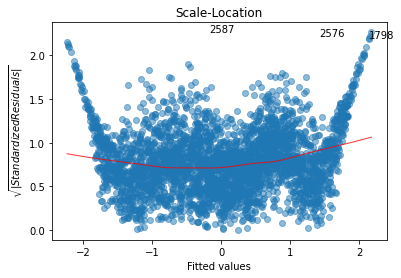

In [12]:
# Reference: https://robert-alvarez.github.io/2018-06-04-diagnostic_plots/

# plot details and formatting
plot_lm_3 = plt.figure()
plt.scatter(model_fitted_y, model_norm_residuals_abs_sqrt, alpha=0.5)
sns.regplot(
    model_fitted_y,
    model_norm_residuals_abs_sqrt,
    scatter=False,
    ci=False,
    lowess=True,
    line_kws={"color": "red", "lw": 1, "alpha": 0.8},
)
plot_lm_3.axes[0].set_title("Scale-Location")
plot_lm_3.axes[0].set_xlabel("Fitted values")
plot_lm_3.axes[0].set_ylabel("$\sqrt{|Standardized Residuals|}$")

# absolute normalized residuals
abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)

# top 3 normalized residuals
abs_norm_resid_top_3 = abs_norm_resid[:3]

# annotations
abs_sq_norm_resid = np.flip(np.argsort(model_norm_residuals_abs_sqrt), 0)
abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]
for i in abs_norm_resid_top_3:
    plot_lm_3.axes[0].annotate(
        i, xy=(model_fitted_y[i], model_norm_residuals_abs_sqrt[i])
    )

In the "Scale-Location" graph, the red line is not horizontal and the points exhibit a quartic function trend. Since the points are not randomly and evenly spread out around the line, the assumption for equal variance does not hold.

## Method #2
After testing that the assumptions for linear regression do not hold, we noticed that our dataset contains structural multicollinearity - new independent variables are created from previous ones. For instance, spl_theme1 is the addition of all the epl (percentile ranking) columns for theme1, which is the Socioeconomic theme.

If there is multicollinearity in the regression model, it leads to the unstable and biased estimation of regression coefficients. By increasing the variance and standard error of coefficients, the statistical power of our model is weakened, defeating the purpose of performing regression on our dataset.

How can we fix this? There are a few methods available:
- Remove the highly correlated independent variables. This can be done by removing one of the variables if two independent variables are highly correlated
    - **Variance Inflation Factor (VIF)** - measures the degree of multicollinearity or collinearity in the regression model)
- Combine the highly correlated independent variables, which we will achieve with **Factor Analysis** later on

In [13]:
# reading in the dataset
df = pd.read_csv("https://raw.githubusercontent.com/gspiga/STA160/main/Final%20Project/Data/data.csv", index_col=[0])
df.head()

,state,county,area_sqmi,epl_pov,epl_unemp,epl_pci,epl_nohsdp,spl_theme1,rpl_theme1,epl_age65,...,f_minrty,f_limeng,f_theme3,f_munit,f_mobile,f_crowd,f_noveh,f_groupq,f_theme4,f_total
0,ALABAMA,Autauga,594.443459,0.5401,0.2745,0.2860,0.4397,1.5403,0.3631,0.1850,...,0,0,0,0,0,0,0,0,0,0
1,ALABAMA,Baldwin,1589.793007,0.2239,0.3121,0.2057,0.3209,1.0626,0.2232,0.6428,...,0,0,0,1,0,0,0,0,1,1
2,ALABAMA,Barbour,885.001636,0.9631,0.9217,0.9481,0.9701,3.8030,0.9780,0.4893,...,0,0,0,0,1,0,0,1,2,8
3,ALABAMA,Bibb,622.461089,0.4430,0.7895,0.8987,0.7351,2.8663,0.7694,0.3200,...,0,0,0,0,1,0,0,1,2,2
4,ALABAMA,Blount,644.830460,0.4723,0.2611,0.7561,0.8405,2.3300,0.6143,0.4715,...,0,0,0,0,0,0,0,0,0,0


In [14]:
# creating dummy variables for flags (binary data)
df_OLS = pd.get_dummies(df,
    columns=[
        "f_pov",
        "f_unemp",
        "f_pci",
        "f_nohsdp",
        "f_age65",
        "f_age17",
        "f_disabl",
        "f_sngpnt",
        "f_minrty",
        "f_limeng",
        "f_munit",
        "f_mobile",
        "f_crowd",
        "f_noveh",
        "f_groupq"
    ],
)

### Variance Inflation Factor (VIF)
We will utilize the variance_inflation_factor package from the statsmodels library to perform feature selection on highly correlated independent predictors. Based on the output of our test, we can determine:

- 1 = complete absence of multicollinearity
- 1-2 = absence of strong multicollinearity
- $>2$ = presence of moderate to strong multicollinearity

Reference: https://www.reneshbedre.com/blog/variance-inflation-factor.html

In [15]:
# building an OLS on current dataset
X = df_OLS.drop(['state', 'county', 'rpl_themes'], axis = 1)
X = sm.add_constant(X)
Y = df_OLS['rpl_themes']
reg = sm.OLS(Y, X).fit()

In [16]:
# calculating variance_inflation_factor (from statsmodels) for each independent variable
pd.DataFrame({'variables':X.columns[1:], 'VIF':[variance_inflation_factor(X.values, i+1) for i in range(len(X.columns[1:]))]})

,variables,VIF
0,area_sqmi,1.120041
1,epl_pov,inf
2,epl_unemp,inf
3,epl_pci,inf
4,epl_nohsdp,inf
5,spl_theme1,inf
6,rpl_theme1,798.402264
7,epl_age65,inf
8,epl_age17,inf
9,epl_disabl,inf


Based on the VIF diagnosis, `area_sqmi` is the only predictor that does not have strong multicollinearity with other predictors. We will recheck the correlation matrix to visualize which predictors are causing multicollinearity, as it is outside the scope of this method.

In [17]:
# correlation matrix
X.corr()

,const,area_sqmi,epl_pov,epl_unemp,epl_pci,epl_nohsdp,spl_theme1,rpl_theme1,epl_age65,epl_age17,...,f_munit_0,f_munit_1,f_mobile_0,f_mobile_1,f_crowd_0,f_crowd_1,f_noveh_0,f_noveh_1,f_groupq_0,f_groupq_1
const,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
area_sqmi,NaN,1.000000,0.016569,0.075059,-0.003528,-0.016718,0.020907,0.019880,-0.068964,0.076435,...,0.021513,-0.021513,0.014449,-0.014449,-0.198211,0.198211,-0.079335,0.079335,-0.013935,0.013935
epl_pov,NaN,0.016569,1.000000,0.635055,0.791417,0.666593,0.905250,0.904765,-0.063324,0.000415,...,0.074223,-0.074223,-0.338628,0.338628,-0.141036,0.141036,-0.301160,0.301160,-0.159643,0.159643
epl_unemp,NaN,0.075059,0.635055,1.000000,0.513375,0.497040,0.774413,0.770999,-0.119086,-0.031613,...,0.040188,-0.040188,-0.266389,0.266389,-0.127597,0.127597,-0.286867,0.286867,-0.069231,0.069231
epl_pci,NaN,-0.003528,0.791417,0.513375,1.000000,0.733303,0.889065,0.888648,0.002170,0.102368,...,0.323756,-0.323756,-0.358601,0.358601,-0.143449,0.143449,-0.186933,0.186933,-0.251712,0.251712
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
f_crowd_1,NaN,0.198211,0.141036,0.127597,0.143449,0.273151,0.200593,0.197642,-0.253504,0.284111,...,-0.034923,0.034923,-0.025282,0.025282,-1.000000,1.000000,-0.074033,0.074033,-0.021293,0.021293
f_noveh_0,NaN,-0.079335,-0.301160,-0.286867,-0.186933,-0.239592,-0.296985,-0.280133,0.124455,0.001403,...,0.103752,-0.103752,0.133880,-0.133880,0.074033,-0.074033,1.000000,-1.000000,0.072581,-0.072581
f_noveh_1,NaN,0.079335,0.301160,0.286867,0.186933,0.239592,0.296985,0.280133,-0.124455,-0.001403,...,-0.103752,0.103752,-0.133880,0.133880,-0.074033,0.074033,-1.000000,1.000000,-0.072581,0.072581
f_groupq_0,NaN,-0.013935,-0.159643,-0.069231,-0.251712,-0.148382,-0.184032,-0.181965,0.133668,0.268879,...,-0.011994,0.011994,0.113391,-0.113391,0.021293,-0.021293,0.072581,-0.072581,1.000000,-1.000000


In [18]:
# list the correlations between every predictor and sort in ascending order
top_corr = X.corr().unstack().sort_values().drop_duplicates()

# pick the highest negatively correlated predictors
print(top_corr.head(10))

# pick the highest positively correlated predictors
print(top_corr.tail(10))

f_munit_1   f_munit_0    -1.000000
f_disabl_0  f_disabl_1   -1.000000
f_limeng_0  f_limeng_1   -1.000000
f_minrty_0  f_minrty_1   -1.000000
f_age17_0   f_age17_1    -1.000000
f_theme3    f_limeng_0   -0.830895
            f_minrty_0   -0.829302
f_theme1    f_pci_0      -0.808678
f_pov_0     f_theme1     -0.808018
f_theme1    f_nohsdp_0   -0.696911
dtype: float64
rpl_theme1  spl_themes    0.893818
spl_themes  spl_theme1    0.895397
rpl_theme1  epl_pov       0.904765
epl_pov     spl_theme1    0.905250
rpl_theme2  spl_theme2    0.966121
spl_theme4  rpl_theme4    0.983788
rpl_theme1  spl_theme1    0.998620
rpl_theme3  spl_theme3    0.998822
area_sqmi   area_sqmi     1.000000
const       const              NaN
dtype: float64


Based on the observed output, we will temporarily remove the following highly correlated predictors: `spl_theme1`, `spl_theme2`, `spl_theme3`, `spl_theme4`, `spl_themes`, `rpl_theme1`, `rpl_theme2`, `rpl_theme3`, `rpl_theme4`.

In [19]:
# remove highly correlated predictors stated above
df_OLS = df_OLS.loc[:, ~df_OLS.columns.str.startswith("spl_")]
df_OLS = df_OLS.drop(['state', 'county', 'rpl_theme1', 'rpl_theme2', 'rpl_theme3', 'rpl_theme4'], axis = 1)
df_OLS

,area_sqmi,epl_pov,epl_unemp,epl_pci,epl_nohsdp,epl_age65,epl_age17,epl_disabl,epl_sngpnt,epl_minrty,...,f_munit_0,f_munit_1,f_mobile_0,f_mobile_1,f_crowd_0,f_crowd_1,f_noveh_0,f_noveh_1,f_groupq_0,f_groupq_1
0,594.443459,0.5401,0.2745,0.2860,0.4397,0.1850,0.7529,0.7905,0.3792,0.6336,...,1,0,1,0,1,0,1,0,1,0
1,1589.793007,0.2239,0.3121,0.2057,0.3209,0.6428,0.4323,0.3524,0.1391,0.5158,...,0,1,1,0,1,0,1,0,1,0
2,885.001636,0.9631,0.9217,0.9481,0.9701,0.4893,0.3327,0.9064,0.9468,0.8965,...,1,0,0,1,1,0,1,0,0,1
3,622.461089,0.4430,0.7895,0.8987,0.7351,0.3200,0.2846,0.6074,0.1706,0.6390,...,1,0,0,1,1,0,1,0,0,1
4,644.830460,0.4723,0.2611,0.7561,0.8405,0.4715,0.6406,0.3763,0.2961,0.4206,...,1,0,1,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3137,10426.975725,0.3127,0.4490,0.1497,0.2668,0.0293,0.9150,0.2041,0.7679,0.5680,...,1,0,1,0,1,0,1,0,1,0
3138,3996.844622,0.0522,0.0264,0.0051,0.0548,0.1334,0.1506,0.0060,0.2216,0.5400,...,1,0,1,0,0,1,1,0,1,0
3139,2081.719807,0.3430,0.6032,0.4443,0.1347,0.0675,0.9685,0.6488,0.2665,0.4136,...,1,0,1,0,1,0,1,0,1,0
3140,2238.672972,0.3360,0.6207,0.4035,0.3792,0.7380,0.7122,0.4448,0.2961,0.5330,...,1,0,1,0,1,0,1,0,1,0


In [20]:
# building the OLS model on our dataset
X = df_OLS.drop(['rpl_themes'], axis = 1)
X = sm.add_constant(X)
Y = df_OLS['rpl_themes']
reg = sm.OLS(Y, X).fit()

In [21]:
# calculating variance_inflation_factor (from statsmodels) for each independent variable
pd.DataFrame({'variables':X.columns[1:], 'VIF':[variance_inflation_factor(X.values, i+1) for i in range(len(X.columns[1:]))]})

,variables,VIF
0,area_sqmi,1.116741
1,epl_pov,4.919446
2,epl_unemp,2.568578
3,epl_pci,5.782249
4,epl_nohsdp,4.187515
5,epl_age65,3.333429
6,epl_age17,3.088097
7,epl_disabl,3.749434
8,epl_sngpnt,2.397269
9,epl_minrty,2.941395


We will also drop the flag columns as based on the correlation matrix outputted earlier, they have strong multicollinearity with one another.

In [22]:
# removing the flags columns and rebuilding the OLS model with current dataset
df_OLS = df_OLS.loc[:, ~df_OLS.columns.str.startswith("f_")]
X = df_OLS.drop(['rpl_themes'], axis = 1)
X = sm.add_constant(X)
Y = df_OLS['rpl_themes']
reg = sm.OLS(Y, X).fit()

# re-calculating variance_inflation_factor (from statsmodels) for each independent variable
pd.DataFrame({'variables':X.columns[1:], 'VIF':[variance_inflation_factor(X.values, i+1) for i in range(len(X.columns[1:]))]})

,variables,VIF
0,area_sqmi,1.059807
1,epl_pov,4.314763
2,epl_unemp,2.186299
3,epl_pci,4.774771
4,epl_nohsdp,3.444706
5,epl_age65,2.602554
6,epl_age17,2.371569
7,epl_disabl,3.027480
8,epl_sngpnt,2.093853
9,epl_minrty,2.423777


While predictors still exhibit high multicollinearity, we will proceed with testing the assumptions for now and revist based on those results.

### Normality Assumption

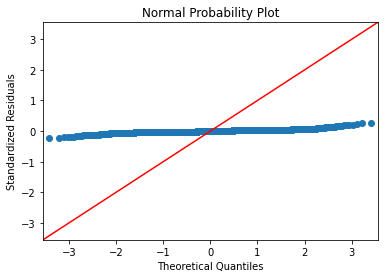

In [23]:
# building the model
model3 = ols("rpl_themes ~  area_sqmi + epl_pov + epl_unemp + epl_pci + epl_nohsdp + epl_age65 + epl_age17 + epl_disabl + epl_sngpnt + epl_minrty + epl_limeng + epl_munit + epl_mobile + epl_crowd + epl_noveh + epl_groupq", data=df_OLS).fit()

# creating the normal probability plot
sm.qqplot(model3.resid, line="45")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Standardized Residuals")
plt.title("Normal Probability Plot")
plt.show()

The points don't follow the line at all, with large quantiles (positive and negative) indicating heavy tails in the data's distribution. The data violates the normality assumption.

#### Box Cox Transformation

We will try performing a BoxCox transformation of the non-normal dependent variable (`rpl_themes`) in an effort to improve the data's compliance to the normality assumption.

In [24]:
# reference: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html
pt = PowerTransformer(method="yeo-johnson")
rpl_themes_df = pd.DataFrame(df_OLS["rpl_themes"])
pt.fit(rpl_themes_df)
print(pt.lambdas_)  # optimal lambda value

[0.74884275]


The above output is the optimal lambda value for the Box Cox transformation of our data. We will use it to transform the `rpl_themes` column and update our model.

In [25]:
# transform the rpl_themes column
transformed_data = pt.transform(rpl_themes_df) # rpl_themes_df
df_OLS.insert(0, "rpl_themes_transformed", transformed_data)  # new column of transformed score

Now that we have transformed the data again, let us recheck the assumptions.

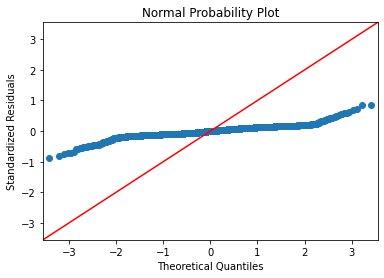

In [26]:
# building the model with the transformed data
model4 = ols("rpl_themes_transformed ~  area_sqmi + epl_pov + epl_unemp + epl_pci + epl_nohsdp + epl_age65 + epl_age17 + epl_disabl + epl_sngpnt + epl_minrty + epl_limeng + epl_munit + epl_mobile + epl_crowd + epl_noveh + epl_groupq", data=df_OLS).fit()

# creating the normal probability plot
sm.qqplot(model4.resid, line="45")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Standardized Residuals")
plt.title("Normal Probability Plot")
plt.show()

Even after the Boxcox transformation, the points don't follow the line at all, with large quantiles (positive and negative) indicating heavy tails in the data's distribution. The data still violates the normality assumption.

#### Shapiro-Wilk's Test
Since the residuals still show heavy tails, we will also perform a Shapiro-Wilk's test to quantify the ability to accept/reject the normality assumption.

In [27]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html
w, pvalue = stats.shapiro(model4.resid)
print(w, pvalue)

0.9297755360603333 4.385920879740134e-36


Since the p-value of 4.385920879740134e-36 is less than $\alpha$ = 0.05, we reject the null hypothesis. There is stiatistically significant evidence to suggest that the normality assumption does not hold.

#### Kolmogorov Smirnoff Test
We will also perform a Kolmogorov Smirnoff test to quantify the ability to accept/reject the normality assumption.

In [28]:
# reference: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kstest.html
stats.kstest(model4.resid, "norm")

KstestResult(statistic=0.40074497769256257, pvalue=0.0)

Since the p-value of 0.0 is less than $\alpha$ = 0.05, we reject the null hypothesis. There is stiatistically significant evidence to suggest that the normality assumption does not hold.

While the results from both of these findings contradict our residuals plot, we will use a histogram to visualize that the residuals are still not normally distributed well.

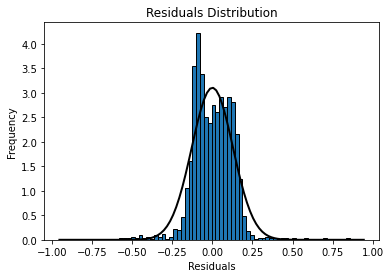

In [29]:
# plot the residuals as a histogram
plt.hist(model4.resid, bins="auto", density=True, histtype="bar", ec="k")
mu, std = norm.fit(model4.resid)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, "k", linewidth=2)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Residuals Distribution")
plt.show()

### Homoscedasticity Assumption

To visualize our data's compliance to the homoscedasticity assumption, we will evaluate the "Residuals vs. Fitted Values" plot, as well as the "Scale-Location" plot. This plot displays the model's fitted values vs. square root of the standardized residuals.

Text(0, 0.5, 'Residuals')

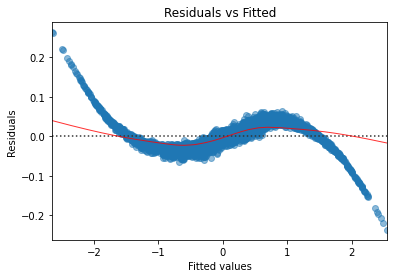

In [30]:
# Reference: https://robert-alvarez.github.io/2018-06-04-diagnostic_plots/

# fitted values
model_fitted_y = model4.fittedvalues
# residuals
model_residuals = model4.resid
# normalized residuals
model_norm_residuals = model4.get_influence().resid_studentized_internal
# absolute squared normalized residuals
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
# absolute residuals
model_abs_resid = np.abs(model_residuals)
# leverage, from statsmodels internals
model_leverage = model4.get_influence().hat_matrix_diag
# cook's distance, from statsmodels internals
model_cooks = model4.get_influence().cooks_distance[0]

# plot details and formatting
plot_lm_1 = plt.figure()
plot_lm_1.axes[0] = sns.residplot(
    model_fitted_y,
    df_OLS.columns[-1],
    data=df_OLS,
    lowess=True,
    scatter_kws={"alpha": 0.5},
    line_kws={"color": "red", "lw": 1, "alpha": 0.8},
)

plot_lm_1.axes[0].set_title("Residuals vs Fitted")
plot_lm_1.axes[0].set_xlabel("Fitted values")
plot_lm_1.axes[0].set_ylabel("Residuals")

The "Residuals vs Fitted" graph has a red line curving about zero. The graph has a scale of 0.1, and the points follow a cubic function trend. Since the red line is not relatively horizontal at 0 and the points are not randomly and evenly spread out around the line, the assumption for equal variance does not hold.

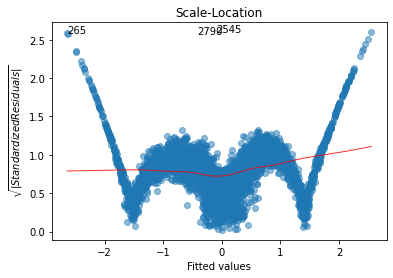

In [31]:
# Reference: https://robert-alvarez.github.io/2018-06-04-diagnostic_plots/

# plot details and formatting
plot_lm_3 = plt.figure()
plt.scatter(model_fitted_y, model_norm_residuals_abs_sqrt, alpha=0.5)
sns.regplot(
    model_fitted_y,
    model_norm_residuals_abs_sqrt,
    scatter=False,
    ci=False,
    lowess=True,
    line_kws={"color": "red", "lw": 1, "alpha": 0.8},
)
plot_lm_3.axes[0].set_title("Scale-Location")
plot_lm_3.axes[0].set_xlabel("Fitted values")
plot_lm_3.axes[0].set_ylabel("$\sqrt{|Standardized Residuals|}$")

# absolute normalized residuals
abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)

# top 3 normalized residuals
abs_norm_resid_top_3 = abs_norm_resid[:3]

# annotations
abs_sq_norm_resid = np.flip(np.argsort(model_norm_residuals_abs_sqrt), 0)
abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]
for i in abs_norm_resid_top_3:
    plot_lm_3.axes[0].annotate(
        i, xy=(model_fitted_y[i], model_norm_residuals_abs_sqrt[i])
    )

In the "Scale-Location" graph, the red line is not horizontal and the points exhibit a quartic function trend. Since the points are not randomly and evenly spread out around the line, in addition to labeled outliers on the plot, the assumption for equal variance does not hold.

Based on our observations of the most recent "Residuals vs. Fitted Values" and "Scale-Location" plots, unfortunately we cannot proceed with Linear Regression. We may want to pursue polynomial regression and cube the predictor variables. We will explore this option next. 